In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from typing import Callable, Dict, List, Optional, Tuple, Union

import mne
from mne.io.edf.edf import RawEDF

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test
DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from utils import read_data
from utils import filter_band_to_raw
from utils import butter_bandpass_filter
from utils import rref_REST
from utils import eliminate_blink_corr_electrodes

DEBUG:root:test


In [3]:
# Load data, filter on 0.1-100 [Hz] and rref REST
raw = read_data("../data/h01.edf")
raw_filtered = filter_band_to_raw(raw, [0.1, 100])
raw_REST = rref_REST(raw_filtered)

Extracting EDF parameters from /Users/Wis/dynamicinfo-eeg/data/h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 8251 samples (33.004 sec)



In [4]:
# Butter filter (order 2) on mean of Fp1 and Fp2 EEG signals
data=np.mean(np.concatenate([raw_REST["Fp1"][0], raw_REST["Fp2"][0]]), axis=0)
ocular_virtual = butter_bandpass_filter(
    data=data, 
    band=[0.1, 5], 
    fs=raw.info["sfreq"], 
    order=2
)
ocular_virtual.shape
#%matplotlib notebook
#plt.plot(np.array(range(len(data)))/raw.info["sfreq"],data, label = 'ocul_virt-pre-filtered')
#plt.plot(np.array(range(len(ocular_virtual)))/raw.info["sfreq"],ocular_virtual, label = 'ocul_virt-_filtered')
#plt.legend()
#plt.show()

(231250,)

In [5]:
# Decomposition ICA
raw_ica = raw_REST.copy()
ica = mne.preprocessing.ICA()
ica.fit(raw_ica)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting all PCA components: 19 components
Fitting ICA took 3.9s.


<ICA | raw data decomposition, fit (fastica): 231250 samples, 19 components, channels used: "eeg">

In [6]:
# Concatenate ocular_virtual with ICA decompositioned data 
virtual_and_ica = np.concatenate([np.expand_dims(ocular_virtual, 0), raw_ica.get_data()], axis=0)
corr = np.corrcoef(virtual_and_ica)
#cov = np.cov(virtual_and_ica)
#cov
#np.diag(cov)

In [7]:
corr

array([[ 1.        ,  0.60329571,  0.06899577, -0.3310651 , -0.3159458 ,
        -0.14383772,  0.4775858 ,  0.11616981, -0.32675232, -0.29294413,
        -0.14559501, -0.05455258, -0.30979027, -0.34632592, -0.02529948,
        -0.27824383, -0.37617761, -0.0078848 , -0.22440032, -0.33209851],
       [ 0.60329571,  1.        ,  0.53204797,  0.03564674, -0.50713551,
        -0.66137249,  0.78417513,  0.35411408, -0.12791819, -0.63315094,
        -0.67576691,  0.40736213,  0.07871713, -0.38113404,  0.35047362,
        -0.0112839 , -0.5326294 ,  0.45206065,  0.10316551, -0.53012301],
       [ 0.06899577,  0.53204797,  1.        ,  0.56105595, -0.09596042,
        -0.61098656,  0.40827946,  0.08714658, -0.03189122, -0.48003291,
        -0.65679885,  0.56331624,  0.4337268 , -0.09592186,  0.19163878,
         0.00369338, -0.44970437,  0.33972113,  0.06654502, -0.49532061],
       [-0.3310651 ,  0.03564674,  0.56105595,  1.        ,  0.39284912,
        -0.37737119, -0.01534525,  0.00808439,  

In [15]:
# find electrodes 'e' with corr(e, ocular_virtual) > threshold
th = 0.6
to_eliminate = eliminate_blink_corr_electrodes(corr, th = th)
print(f'Threshold: {th} => Eliminate ICA component(s):{to_eliminate}.')

Threshold: 0.6 => Eliminate ICA component(s):[0].


DEBUG:matplotlib.backends:backend nbAgg version unknown


<IPython.core.display.Javascript object>


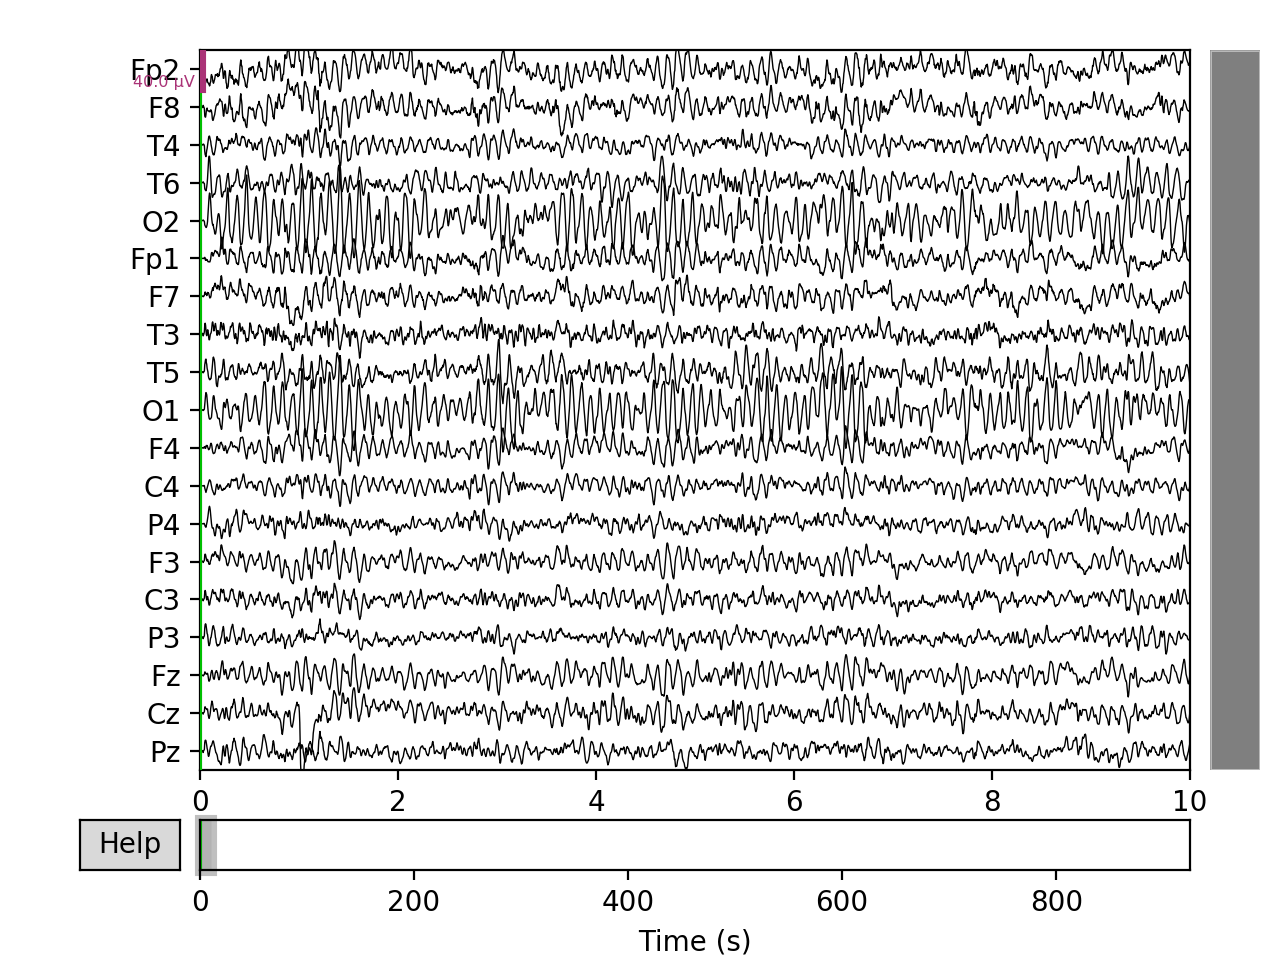

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=5.789999999999999 to DejaVu Sans ('/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


<IPython.core.display.Javascript object>


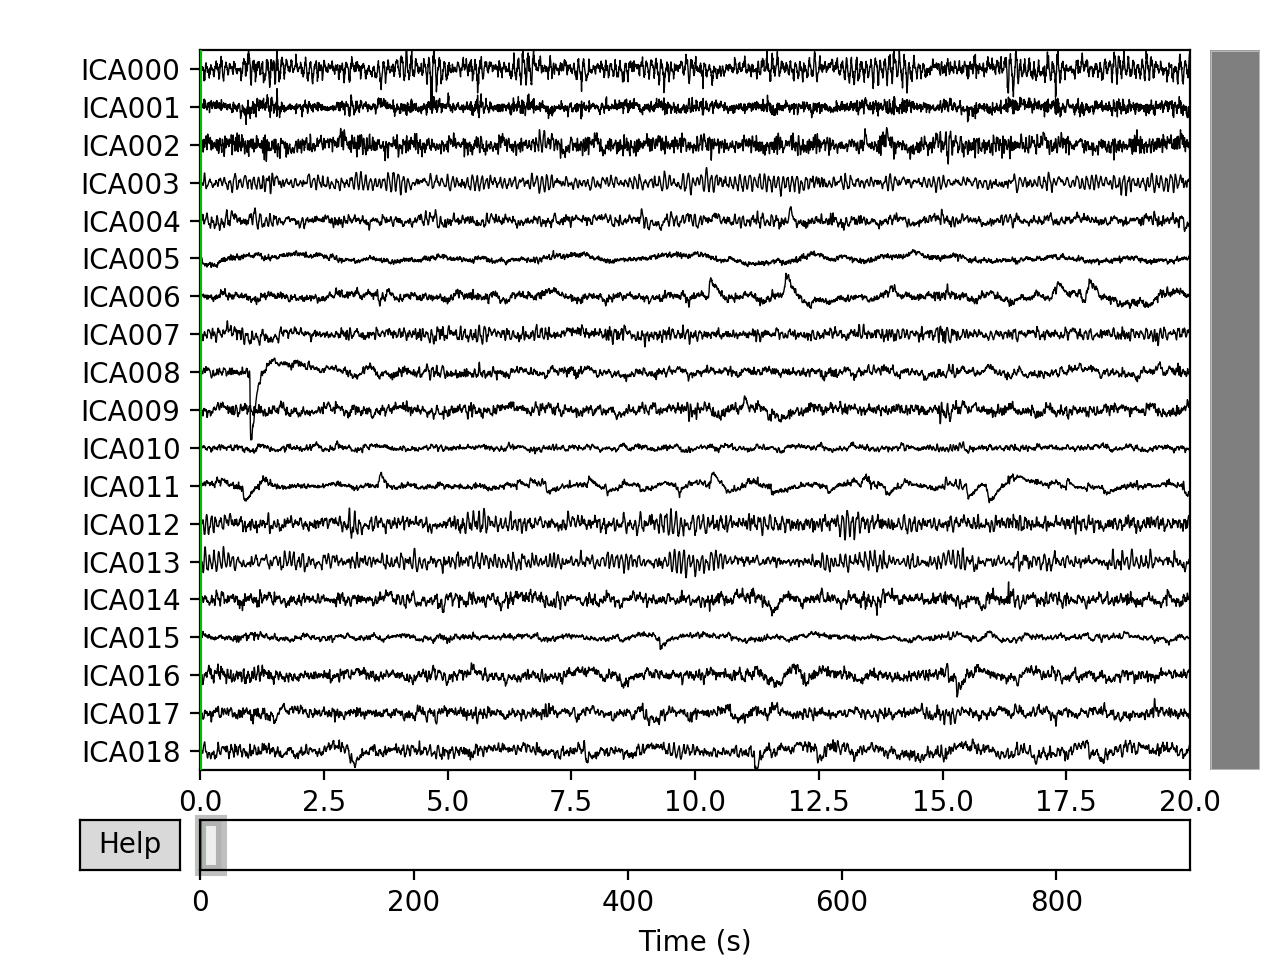

In [9]:
%matplotlib notebook
raw_REST.plot()
ica.plot_sources(raw_ica)
plt.show()

In [10]:
#ica.plot_components(inst=raw_REST) # Project mixing matrix on interpolated sensor topography.

Transforming to ICA space (19 components)
Zeroing out 1 ICA component


<IPython.core.display.Javascript object>


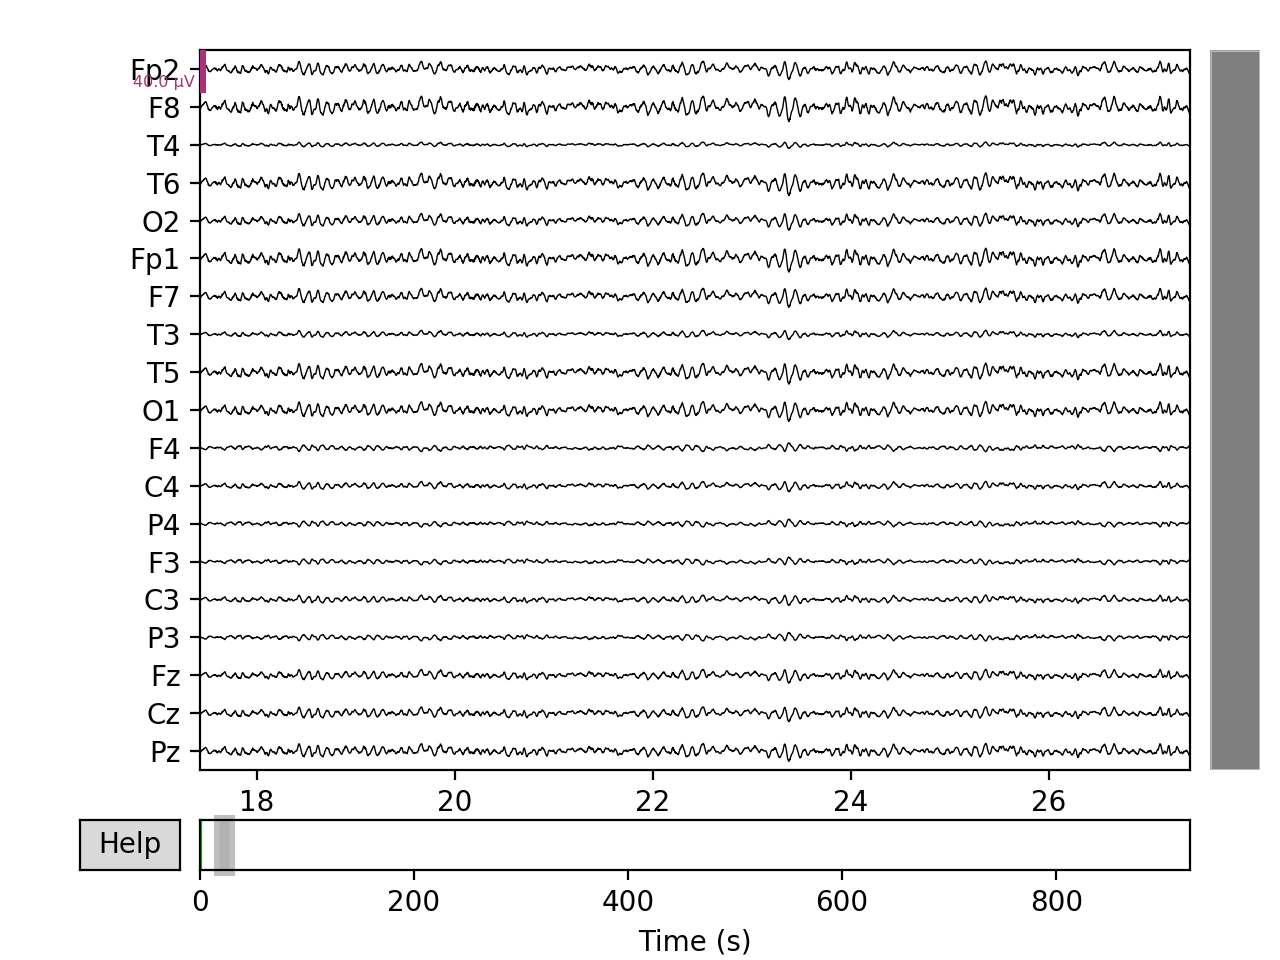

In [11]:
ica.apply(raw, exclude = to_eliminate) # Remove selected components from the signal
raw.plot()
plt.show()

Transforming to ICA space (19 components)
Zeroing out 0 ICA components


<IPython.core.display.Javascript object>


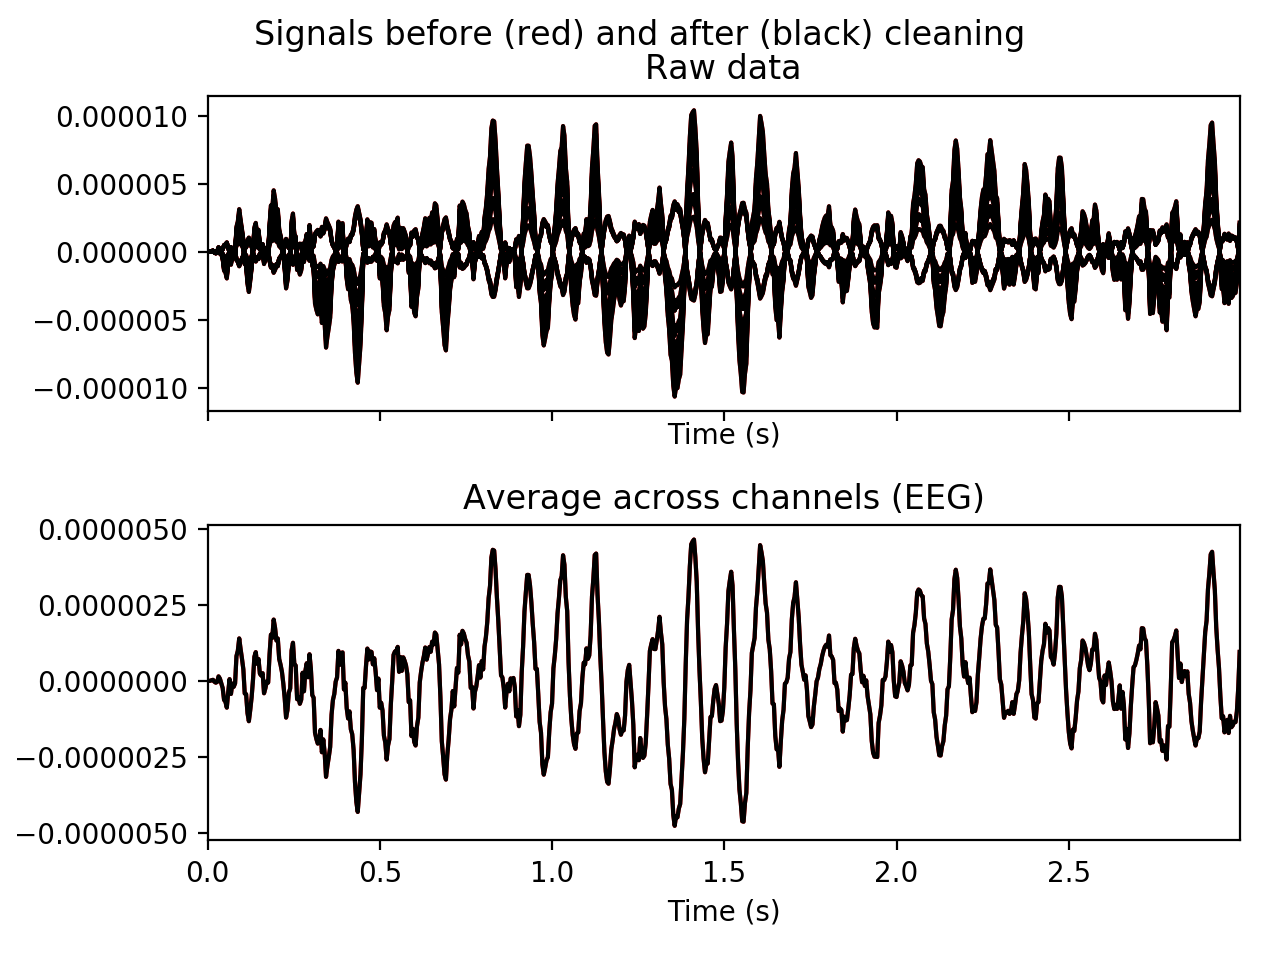

DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/anaconda2/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


In [12]:
ica.plot_overlay(raw)
plt.show()